# CP 4 Aprendizaje de Máquinas
---

## Regresión Logística

En esta clase práctica, seguiremos usando el dataset de _Rotten Tomatoes_ para clasificar críticas positivas y negativas. Como en las clases anteriores, extraemos el contenido de los archivos.

In [46]:
from pathlib import Path

path_p = Path("txt_sentoken/pos")
path_n = Path("txt_sentoken/neg")

ds_p = list(path_p.iterdir())     # directorio donde están las críticas positivas
ds_n = list(path_n.iterdir())     # directorio donde están las críticas negativas

def convert_file_to_text(file_path: Path) -> str:
    with open(file_path) as f:
        return ''.join(f.readlines())
    
texts_p = [convert_file_to_text(file) for file in ds_p]    # Lista de críticas positivas
texts_n = [convert_file_to_text(file) for file in ds_n]    # Lista de críticas negativas

### Ejercicio 1: Regresión Logística aplicado al dataset de _Rotten Tomatoes_

In [47]:
from sklearn.feature_extraction.text import CountVectorizer 

cv = CountVectorizer()
X = cv.fit_transform(texts_p + texts_n)
X = X.toarray()

y = [1]*1000 + [0]*1000

In [48]:
X.shape

(2000, 39659)

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=23)

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
lr_model = LogisticRegression(solver='liblinear', max_iter=1000)
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.81

### Ejercicio 2: Aplicando la Matriz de Confusión

In [52]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

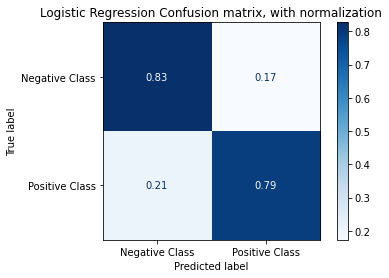

In [53]:
disp = plot_confusion_matrix(lr_model, X_test, y_test,
                             display_labels=['Negative Class', 'Positive Class'],
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

### Ejercicio 3: Probando la clasificación de un texto en específico

In [54]:
lr_model.classes_

array([0, 1])

In [55]:
test_review = cv.transform(["The movie was not fun to watch"])
lr_model.predict_proba(test_review)

array([[0.47988569, 0.52011431]])

### Ejercicio 4: Vizualizando los Features más Importantes

In [67]:
import numpy as np
import seaborn as sns

In [68]:
feature_importance = lr_model.coef_[0]
sorted_idx = np.argsort(feature_importance)

In [69]:
top_10_pos_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_w)

['fun', 'quite', 'back', 'great', 'see', 'ben', 'well', 'seen', 'performance', 'always']


In [70]:
top_10_pos_importance = feature_importance[sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_importance)

[0.54422013 0.39439874 0.37513935 0.36671324 0.35290454 0.3401429
 0.33351279 0.32880539 0.32798958 0.32156777]


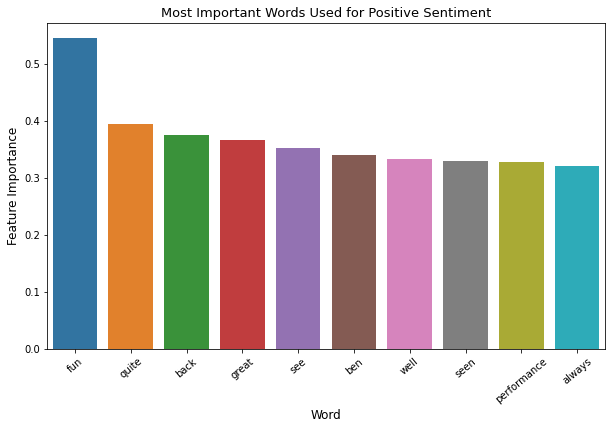

In [71]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_pos_w, y=top_10_pos_importance)
plt.title("Most Important Words Used for Positive Sentiment", fontsize=13)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation=40)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Word', fontsize = 12);

In [72]:
top_10_neg_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]
print(top_10_neg_w)

['bad', 'worst', 'unfortunately', 'looks', 'any', 'nothing', 'boring', 'awful', 'script', 'through']


In [73]:
top_10_neg_importance = feature_importance[sorted_idx[:10]]
print(top_10_neg_importance)

[-0.62402099 -0.59591589 -0.55308501 -0.46475953 -0.42456335 -0.41363352
 -0.40823836 -0.39915508 -0.3913603  -0.39125439]


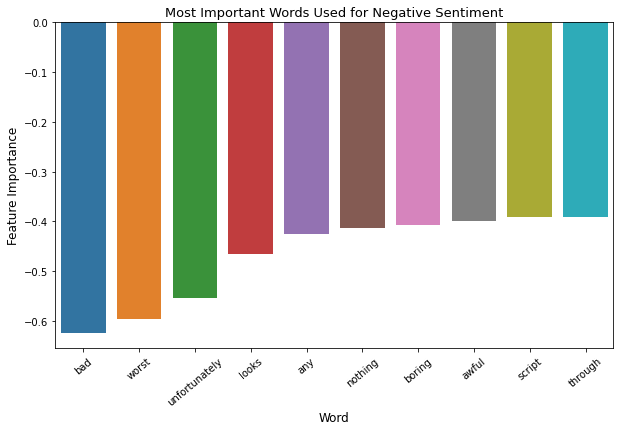

In [74]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_neg_w, y=top_10_neg_importance)
plt.title("Most Important Words Used for Negative Sentiment", fontsize = 13)
x_locs, x_labels = plt.xticks()
plt.setp(x_labels, rotation=40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

### Ejercicio 7: Ideas Para Mejorar: Añadir bigramas

In [75]:
important_words = top_10_pos_w[:5] + top_10_neg_w[:5]
unigram_vocab = list(cv.vocabulary_.keys())
bigram_vocab = []
for word in important_words:
    for unigram in unigram_vocab:
        if word != unigram:
            bigram_vocab.append(f"{word} {unigram}")
            bigram_vocab.append(f"{unigram} {word}")

            
new_vocab = unigram_vocab + bigram_vocab
new_vocab = set(new_vocab)
len(bigram_vocab)

793160

In [80]:
cv = CountVectorizer(min_df=2,ngram_range = (1,2))
X = cv.fit_transform(texts_p + texts_n)
X = X.toarray()
X.shape

(2000, 139448)

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=23)

In [82]:
lr_model = LogisticRegression(solver='liblinear', max_iter=1000)
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.8483333333333334

In [83]:
test_review = cv.transform(["The movie was not fun to watch"])
lr_model.predict_proba(test_review)

array([[0.51134957, 0.48865043]])

### Ejercicio 8: Ideas para Mejorar: Disminuir el umbral de corte de probabilidad

In [84]:
import pandas as pd
from sklearn.metrics import accuracy_score

In [85]:
pred_proba_df = pd.DataFrame(lr_model.predict_proba(X_test))
threshold_list = [0.3, 0.4, 0.45, 0.5]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = round(accuracy_score(y_test, Y_test_pred.loc[:,1].values),3)
    print('Accuracy: {}'.format(test_accuracy))


******** For i = 0.3 ******
Accuracy: 0.838

******** For i = 0.4 ******
Accuracy: 0.85

******** For i = 0.45 ******
Accuracy: 0.85

******** For i = 0.5 ******
Accuracy: 0.848
